# Guided (sparse) Hamiltonian Problem

In [14]:
from attrs import frozen
import attrs
from qualtran import Bloq, Signature, Register, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from qualtran.symbolics import SymbolicInt, ceil, log2, ln, is_symbolic
from qualtran.resource_counting import big_O
from qualtran.resource_counting.generalizers import ignore_alloc_free, ignore_split_join, ignore_cliffords
from qualtran.bloqs.block_encoding import BlockEncoding
from qualtran.bloqs.reflections.reflection_using_prepare import ReflectionUsingPrepare
from qualtran.bloqs.max_k_xor_sat.guided_hamiltonian import GuidedHamiltonian
from qualtran.bloqs.max_k_xor_sat.shims import ArbitraryGate # arbitrary 1/2-qubit gate, for costing.

## `GuidedHamiltonian`
Solve the guided (sparse) hamiltonian problem.

Definition 4.8 (modified with sparsity generalized to any):
In the Guided Hamiltonian problem we are given the following as input:

1. A Hamiltonian $H$ with $\|H\|_\max \le 1$, specified via a block-encoding.
2. A unitary program that takes $|0^N\rangle|0^A\rangle$ and prepares $|\Psi\rangle|0^A\rangle$.
3. Parameters $\lambda \in [-\Lambda, \Lambda]$, $\alpha \in (0, 1)$, $\gamma \in (0, 1]$.

and we should output

- YES if $\| \Pi_{\ge \lambda} (H) |\Psi\rangle \| \ge \gamma$
- NO if $\|H\| \le (1 - \alpha) \lambda$

Note that the above drops the sparse requirement, and accepts any
$(\alpha_H, \cdot, \cdot)$-block-encoding of $H$.
In the sparse Hamiltonian case, $\alpha_H = s$ (where $s$ is the sparsity).

Algorithm (Theorem 4.9):
    This uses phase estimation on the block-encoding of $e^{iHt}$, and then uses
    amplitude amplification to increase the success probability to $1 - o(1)$.

We instead directly do phase-estimation on the qubitized (Szegedy) walk operator for $H$.

#### Parameters
 - `hamiltonian`: the block-encoding of $H$
 - `guiding_state`: the unitary that prepares $|\Psi\rangle$
 - `lambd`: parameter $\lambda$
 - `alpha`: parameter $\alpha$
 - `gamma`: parameter $\gamma$ 

# Computing Query Costs with Qualtran

We will first create black-boxes for a Hamiltonian and a guiding state preparation, that can be passed to the `GuidedHamiltonian` bloq to count number of queries and gates.

## Building black-box oracles

### Graph oracles for the Hamiltonian
We first build the oracles $O_F$ and $O_H$, and use them to block-encode a sparse matrix.

In [16]:
@frozen
class oracle_O_H(Bloq):
    """given (i, j), output H_{i, j}"""
    N: SymbolicInt
    entry_bits: SymbolicInt
    
    @property
    def signature(self):
        return Signature.build(i=self.N, j=self.N, entry=self.entry_bits)

    def adjoint(self):
        return self

@frozen
class oracle_O_F(Bloq):
    """Given (i, k), output (i, f(i, k)) s.t. f(i, k) is the k-th non zero entry in row i"""
    N: SymbolicInt
    reverse: bool = False
    
    @property
    def signature(self):
        return Signature.build(i=self.N, k=self.N)

    def adjoint(self):
        return oracle_O_F(self.N, reverse=not self.reverse)


@frozen
class EncodeSparseHamiltonian(BlockEncoding):
    """(s, N+1, 0)-block-encoding of s-sparse NxN matrix H"""
    N: SymbolicInt
    s: SymbolicInt # sparsity
    O_F: oracle_O_F
    O_H: oracle_O_H

    @property
    def signature(self) -> Signature:
        return Signature.build_from_dtypes(
            system=QAny(self.system_bitsize),
            ancilla=QAny(self.ancilla_bitsize),
        )

    @property
    def system_bitsize(self):
        return self.N

    @property
    def ancilla_bitsize(self):
        return self.N + 1

    @property
    def resource_bitsize(self):
        return 0

    @property
    def alpha(self):
        return self.s

    @property
    def epsilon(self):
        return 0

    @property
    def signal_state(self):
        from qualtran.bloqs.reflections.prepare_identity import PrepareIdentity
        from qualtran.bloqs.state_preparation.black_box_prepare import BlackBoxPrepare
        
        return BlackBoxPrepare(PrepareIdentity.from_bitsizes([self.ancilla_bitsize]))

    def build_call_graph(self, ssa):
        """
        References:
            [Lecture Notes on Quantum Algorithms for Scientific Computation](https://arxiv.org/abs/2201.08309). Lin Lin (2022). Ch. 6.5.
        """
        log_s = ceil(log2(self.s))
        return {(self.O_F, 2), (self.O_H, 2), (ArbitraryGate(), 2*log_s)}

### State-preparation Oracle for the guiding state

Point 2.  Quantum circuit that uses $G$ gates and maps $|0^N\rangle|0^A\rangle$ to $|\Psi\rangle|0^A\rangle$

In [17]:
@frozen
class GuidingState(Bloq):
    """Point 2. Quantum circuit that uses G gates and maps |0^N>|0^A> to |\Psi>|0^A>"""
    N: SymbolicInt
    A: SymbolicInt
    G: SymbolicInt
    
    @property
    def signature(self) -> Bloq:
        return Signature.build(selection=self.N, junk=self.A)

    def build_call_graph(self, ssa):
        return {(ArbitraryGate(), self.G)}
    
    @property
    def selection_bitsize(self):
        return self.N
    @property
    def junk_bitsize(self):
        return self.A
    @property
    def selection_registers(self):
        return (Register('selection', QAny(self.N)),)
    @property
    def junk_registers(self):
        return (Register('junk', QAny(self.A)),)

## An example invocation
With these oracles in place, we can now invoke the `GuidedHamiltonian` algorithm.

In [18]:
import sympy

def example_bloq() -> GuidedHamiltonian:
    N, A, G, s = sympy.symbols("N A G s", positive=True, integer=True)
    lambd, alpha, gamma = sympy.symbols(r"\lambda \alpha \gamma", positive=True, real=True)

    O_F = oracle_O_F(N)
    O_H = oracle_O_H(N, 10)
    be_H = EncodeSparseHamiltonian(N, s, O_F, O_H)
    psi = GuidingState(N, A, G)

    return GuidedHamiltonian(be_H, psi, lambd, alpha, gamma)

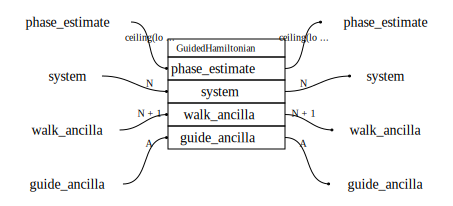

In [19]:
bloq = example_bloq()
show_bloq(bloq)

## Circuit Diagrams

We will now look at the decomposition of the bloq, to see the steps of the algorithm.
First we look at the phase estimation bloq $U_\text{PE}$.
To obtain the entire algorithm, we use amplitude-amplification on $U_\text{PE}$ for $O(1/\gamma)$ rounds.
The good subspace is characterized by `guide_ancilla` being all 0.

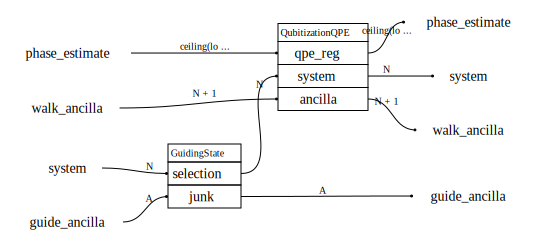

In [21]:
show_bloq(bloq.qpe_bloq.decompose_bloq())

### Full Circuit
For exposition, let us pick the number of rounds as a constant (say, $3$) to see the decomposition:

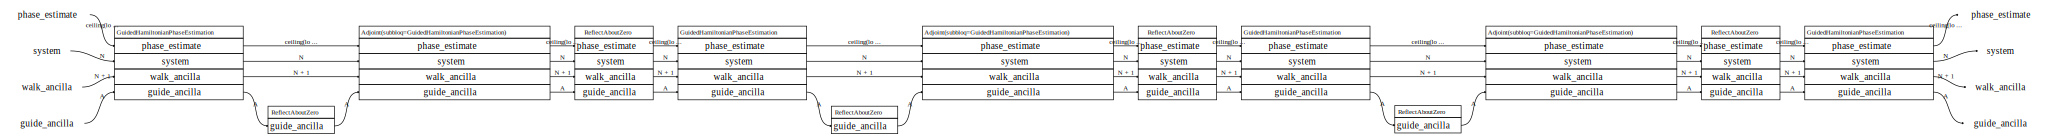

In [23]:
bloq_4_rounds = attrs.evolve(bloq, gamma=1/3)
show_bloq(bloq_4_rounds.decompose_bloq())

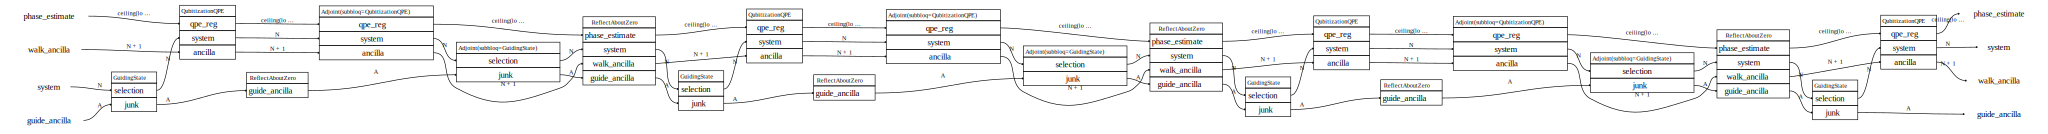

In [25]:
show_bloq(bloq_4_rounds.decompose_bloq().flatten_once())

## Query and gate costs
We will count queries to the above oracles, and arbitrary 1/2-qubit gates as described in the paper.

In [27]:
from qualtran.bloqs.max_k_xor_sat.shims import generalize_1_2_qubit_gates

g, sigma = bloq.call_graph(
    generalizer=[ignore_alloc_free, ignore_split_join, generalize_1_2_qubit_gates]
)

In [29]:
show_counts_sigma(sigma)

#### Counts totals:
 - `And`: $\displaystyle \left(\left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right) \left(4 \cdot 2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} + N \left(2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} - 2\right) + N \left(2 \left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil - 2\right) + N - 4\right) + \left(A + 2 N + \left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil\right) \left\lceil{\frac{1}{\gamma}}\right\rceil + \left(4 \cdot 2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} + N \left(2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} - 2\right) + N \left(2 \left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil - 2\right) + N - 4\right) \left\lceil{\frac{1}{\gamma}}\right\rceil$
 - `And†`: $\displaystyle \left(\left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right) \left(4 \cdot 2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} + N \left(2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} - 2\right) + N \left(2 \left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil - 2\right) + N - 4\right) + \left(A + 2 N + \left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil\right) \left\lceil{\frac{1}{\gamma}}\right\rceil + \left(4 \cdot 2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} + N \left(2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} - 2\right) + N \left(2 \left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil - 2\right) + N - 4\right) \left\lceil{\frac{1}{\gamma}}\right\rceil$
 - `ArbitraryGate`: $\displaystyle 2 \left(\left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right) \left\lceil{\operatorname{log}_{2}{\left(s \right)}}\right\rceil + 2 \left\lceil{\frac{1}{\gamma}}\right\rceil \left\lceil{\operatorname{log}_{2}{\left(s \right)}}\right\rceil$
 - `ArbitraryGate`: $\displaystyle \left(\left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right) \left(4 \cdot 2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} \left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil + G + \left(2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} - 2\right) \left(2 \left\lceil{\operatorname{log}_{2}{\left(s \right)}}\right\rceil + 3\right) + \left(\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil - 1\right) \left\lfloor{\frac{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil}{2}}\right\rfloor + 13 \left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(\left\lfloor{2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil}}\right\rfloor \right)}}\right\rceil + \left\lfloor{\frac{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil}{2}}\right\rfloor - 16\right) + \left(4 \cdot 2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} \left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil + G + \left(2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} - 2\right) \left(2 \left\lceil{\operatorname{log}_{2}{\left(s \right)}}\right\rceil + 3\right) + \left(\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil - 1\right) \left\lfloor{\frac{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil}{2}}\right\rfloor + 13 \left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil + 2 \left\lceil{\operatorname{log}_{2}{\left(\left\lfloor{2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil}}\right\rfloor \right)}}\right\rceil + \left\lfloor{\frac{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil}{2}}\right\rfloor - 16\right) \left\lceil{\frac{1}{\gamma}}\right\rceil + 2 \left\lceil{\frac{1}{\gamma}}\right\rceil$
 - `C[oracle_O_F]`: $\displaystyle 2 \left\lceil{\frac{1}{\gamma}}\right\rceil + 2$
 - `C[oracle_O_F]`: $\displaystyle 2 \left\lceil{\frac{1}{\gamma}}\right\rceil$
 - `C[oracle_O_H]`: $\displaystyle 4 \left\lceil{\frac{1}{\gamma}}\right\rceil + 2$
 - `PrepareIdentity`: $\displaystyle \left(\left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right) \left(2 \cdot 2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} + 4 \left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil - 6\right) + \left(2 \cdot 2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} + 4 \left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil - 6\right) \left\lceil{\frac{1}{\gamma}}\right\rceil$
 - `oracle_O_F`: $\displaystyle \left(2 \cdot 2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} - 4\right) \left(\left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right)$
 - `oracle_O_F`: $\displaystyle \left(2 \cdot 2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} - 4\right) \left\lceil{\frac{1}{\gamma}}\right\rceil$
 - `oracle_O_H`: $\displaystyle \left(2 \cdot 2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} - 4\right) \left(\left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right) + \left(2 \cdot 2^{\left\lceil{\operatorname{log}_{2}{\left(\frac{s \log{\left(\frac{1}{\gamma^{3}} \right)}}{\alpha \lambda} \right)}}\right\rceil} - 4\right) \left\lceil{\frac{1}{\gamma}}\right\rceil$

### Cost from the paper
Theorem 4.9 of the paper states that the algorithm uses:
1. $Q = \widetilde{O}(s / (\gamma \alpha \lambda))$ queries to oracles for H
2. $\widetilde{O}(G/\gamma + \text{polylog}(Q)/\gamma + QN)$ gates

Let us simplify the symbolic costs obtained above and verify if they match.

In [31]:
def simplify_2_pow_log(my_expr, inner_term):
    # replace `2**(ceil(log2(T)))` upper bound `2T`.
    temp = sympy.symbols(f"_temp", positive=True, integer=True)
    my_expr = my_expr.replace(ceil(log2(inner_term)), temp)
    my_expr = my_expr.replace(2**temp, 2 * inner_term)
    my_expr = my_expr.replace(temp, ceil(log2(inner_term)))
    return my_expr

def simplify_expression(expr):
    if not is_symbolic(expr): return expr
    N, A, G, s = sympy.symbols("N A G s", positive=True, integer=True)
    lambd, alpha, gamma = sympy.symbols(r"\lambda \alpha \gamma", positive=True, real=True)

    expr = simplify_2_pow_log(expr, (s * ln(1/gamma**3)) / (alpha * lambd))
    expr = sympy.simplify(expr)
    return expr

sigma_simpl = {k: simplify_expression(v) for k, v in sigma.items()}
show_counts_sigma(sigma_simpl)

#### Counts totals:
 - `And`: $\displaystyle \frac{\alpha \lambda \left(A + 2 N + \left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil\right) \left\lceil{\frac{1}{\gamma}}\right\rceil + \left(\left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right) \left(- 2 N \left(\alpha \lambda + 3 s \log{\left(\gamma \right)}\right) + \alpha \lambda \left(2 N \left(\left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil - 1\right) + N - 4\right) - 24 s \log{\left(\gamma \right)}\right) + \left(- 2 N \left(\alpha \lambda + 3 s \log{\left(\gamma \right)}\right) + \alpha \lambda \left(2 N \left(\left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil - 1\right) + N - 4\right) - 24 s \log{\left(\gamma \right)}\right) \left\lceil{\frac{1}{\gamma}}\right\rceil}{\alpha \lambda}$
 - `And†`: $\displaystyle \frac{\alpha \lambda \left(A + 2 N + \left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil\right) \left\lceil{\frac{1}{\gamma}}\right\rceil + \left(\left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right) \left(- 2 N \left(\alpha \lambda + 3 s \log{\left(\gamma \right)}\right) + \alpha \lambda \left(2 N \left(\left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil - 1\right) + N - 4\right) - 24 s \log{\left(\gamma \right)}\right) + \left(- 2 N \left(\alpha \lambda + 3 s \log{\left(\gamma \right)}\right) + \alpha \lambda \left(2 N \left(\left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil - 1\right) + N - 4\right) - 24 s \log{\left(\gamma \right)}\right) \left\lceil{\frac{1}{\gamma}}\right\rceil}{\alpha \lambda}$
 - `ArbitraryGate`: $\displaystyle 2 \cdot \left(2 \left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right) \left\lceil{\operatorname{log}_{2}{\left(s \right)}}\right\rceil$
 - `ArbitraryGate`: $\displaystyle \frac{2 \alpha \lambda \left\lceil{\frac{1}{\gamma}}\right\rceil + \left(\left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right) \left(\alpha \lambda \left(G + \left(\left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil - 1\right) \left\lfloor{\frac{\left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil}{2}}\right\rfloor + 15 \left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil + \left\lfloor{\frac{\left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil}{2}}\right\rfloor - 16\right) - 24 s \log{\left(\gamma \right)} \left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil - 2 \left(\alpha \lambda + 3 s \log{\left(\gamma \right)}\right) \left(2 \left\lceil{\operatorname{log}_{2}{\left(s \right)}}\right\rceil + 3\right)\right) + \left(\alpha \lambda \left(G + \left(\left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil - 1\right) \left\lfloor{\frac{\left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil}{2}}\right\rfloor + 15 \left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil + \left\lfloor{\frac{\left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil}{2}}\right\rfloor - 16\right) - 24 s \log{\left(\gamma \right)} \left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil - 2 \left(\alpha \lambda + 3 s \log{\left(\gamma \right)}\right) \left(2 \left\lceil{\operatorname{log}_{2}{\left(s \right)}}\right\rceil + 3\right)\right) \left\lceil{\frac{1}{\gamma}}\right\rceil}{\alpha \lambda}$
 - `C[oracle_O_F]`: $\displaystyle 2 \left\lceil{\frac{1}{\gamma}}\right\rceil + 2$
 - `C[oracle_O_F]`: $\displaystyle 2 \left\lceil{\frac{1}{\gamma}}\right\rceil$
 - `C[oracle_O_H]`: $\displaystyle 4 \left\lceil{\frac{1}{\gamma}}\right\rceil + 2$
 - `PrepareIdentity`: $\displaystyle \frac{2 \left(\alpha \lambda \left(2 \left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil - 3\right) - 6 s \log{\left(\gamma \right)}\right) \left(2 \left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right)}{\alpha \lambda}$
 - `oracle_O_F`: $\displaystyle - \frac{4 \left(\alpha \lambda + 3 s \log{\left(\gamma \right)}\right) \left(\left\lceil{\frac{1}{\gamma}}\right\rceil + 1\right)}{\alpha \lambda}$
 - `oracle_O_F`: $\displaystyle \frac{4 \left(- \alpha \lambda - 3 s \log{\left(\gamma \right)}\right) \left\lceil{\frac{1}{\gamma}}\right\rceil}{\alpha \lambda}$
 - `oracle_O_H`: $\displaystyle \frac{4 \left(\alpha \lambda + 3 s \log{\left(\gamma \right)}\right) \left(- 2 \left\lceil{\frac{1}{\gamma}}\right\rceil - 1\right)}{\alpha \lambda}$

### Cost of Phase Estimation

For simplicity, we can also look at the cost of a single phase estimation call (which is repeated $1/\gamma$ times to obtain the above algorithm).

In [32]:
g_pe, sigma_pe = bloq.qpe_bloq.call_graph(
    generalizer=[ignore_alloc_free, ignore_split_join, generalize_1_2_qubit_gates]
)
sigma_pe = {k: simplify_expression(v) for k, v in sigma_pe.items()}
show_counts_sigma(sigma_pe)

#### Counts totals:
 - `And`: $\displaystyle 2 N \left\lceil{\operatorname{log}_{2}{\left(- \log{\left(\gamma^{\frac{3 s}{\alpha \lambda}} \right)} \right)}}\right\rceil - 3 N - 4 - \frac{\log{\left(\gamma^{24 s} \gamma^{6 N s} \right)}}{\alpha \lambda}$
 - `And†`: $\displaystyle 2 N \left\lceil{\operatorname{log}_{2}{\left(- \log{\left(\gamma^{\frac{3 s}{\alpha \lambda}} \right)} \right)}}\right\rceil - 3 N - 4 - \frac{\log{\left(\gamma^{24 s} \gamma^{6 N s} \right)}}{\alpha \lambda}$
 - `ArbitraryGate`: $\displaystyle 2 \left\lceil{\operatorname{log}_{2}{\left(s \right)}}\right\rceil$
 - `ArbitraryGate`: $\displaystyle G - 4 \left\lceil{\operatorname{log}_{2}{\left(s \right)}}\right\rceil + \left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil \left\lfloor{\frac{\left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil}{2}}\right\rfloor + 15 \left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil - 22 - \frac{12 s \log{\left(\gamma \right)} \left\lceil{\operatorname{log}_{2}{\left(s \right)}}\right\rceil}{\alpha \lambda} - \frac{24 s \log{\left(\gamma \right)} \left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil}{\alpha \lambda} - \frac{18 s \log{\left(\gamma \right)}}{\alpha \lambda}$
 - `C[oracle_O_F]`: 2
 - `C[oracle_O_H]`: 2
 - `PrepareIdentity`: $\displaystyle 4 \left\lceil{\operatorname{log}_{2}{\left(- \frac{3 s \log{\left(\gamma \right)}}{\alpha \lambda} \right)}}\right\rceil - 6 - \frac{12 s \log{\left(\gamma \right)}}{\alpha \lambda}$
 - `oracle_O_F`: $\displaystyle -4 - \frac{12 s \log{\left(\gamma \right)}}{\alpha \lambda}$
 - `oracle_O_H`: $\displaystyle -4 - \frac{12 s \log{\left(\gamma \right)}}{\alpha \lambda}$